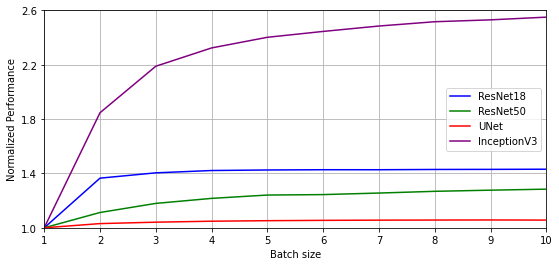

res:  724.113 1036.27 1.4310887941522938
r50:  287.026 368.65 1.2843784186798408
unt:  245.7 259.875 1.0576923076923077
inc:  164.123 418.533 2.550117899380343
i48:  41.0357 68.0078 1.6572837797332567
[1.0, 1.1125681993965704, 1.1795516782451765, 1.2164821305386968, 1.2410060412645545, 1.2443611380153714, 1.2556911220586289, 1.2684669681492269, 1.276866904043536, 1.2843784186798408]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

resBatchData = pd.read_csv('batching/res.csv')
untBatchData = pd.read_csv('batching/unt.csv')
incBatchData = pd.read_csv('batching/inc.csv')
r50BatchData = pd.read_csv('batching/res50.csv')
i48BatchData = pd.read_csv('batching/inc448.csv')

resBatch = resBatchData.max(axis=0)
untBatch = untBatchData.max(axis=0)
incBatch = incBatchData.max(axis=0)
r50Batch = r50BatchData.max(axis=0)
i48Batch = i48BatchData.max(axis=0)

# print(resBatchData)
# print(resAverage)

# resBatch = resBatchData.iloc[:, 1].tolist()
# untBatch = untBatchData.iloc[:, 1].tolist()
# incBatch = incBatchData.iloc[:, 1].tolist()
# r50Batch = r50BatchData.iloc[:, 1].tolist()

resNorm = [fps / resBatch[0] for fps in resBatch]
untNorm = [fps / untBatch[0] for fps in untBatch]
incNorm = [fps / incBatch[0] for fps in incBatch]
r50Norm = [fps / r50Batch[0] for fps in r50Batch]
i48Norm = [fps / i48Batch[0] for fps in i48Batch]

x = np.arange(1, len(resBatch) + 1)  # x-values

bar_width = 0.0  # width of the bars

colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
plt.figure(figsize=(9, 4.))

plt.plot(x - bar_width * 1.5, resNorm, color=colors[0], label='ResNet18')
plt.plot(x - bar_width * 0.5, r50Norm, color=colors[1], label='ResNet50')
plt.plot(x + bar_width * 0.5, untNorm, color=colors[2], label='UNet')
plt.plot(x + bar_width * 1.5, incNorm, color=colors[3], label='InceptionV3')

# plt.plot(x - bar_width * 2, resNorm, color=colors[0], label='ResNet18')
# plt.plot(x - bar_width * 1, r50Norm, color=colors[1], label='ResNet50')
# plt.plot(x + bar_width * 0, untNorm, color=colors[2], label='UNet')
# plt.plot(x + bar_width * 1, incNorm, color=colors[3], label='InceptionV3')
# plt.plot(x + bar_width * 2, i48Norm, color=colors[4], label='InceptionV3 448')

# plt.plot(x - bar_width, resBatch, color='blue', label='ResNet18')
# plt.plot(x + 2 * bar_width, r50Batch, color='orange', label='ResNet50')
# plt.plot(x, untBatch, color='green', label='UNet')
# plt.plot(x + bar_width, incBatch, color='red', label='InceptionV3')

plt.xticks(x, [str(i) for i in x])

plt.xlabel('Batch size')
plt.ylabel('Normalized Performance')
plt.legend()
# plt.title('Normalized Performace vs Batch Size')
plt.grid(True)

plt.xlim(1, 10)
plt.yticks(np.arange(1, 2.8, 0.4))
plt.ylim(1, 2.6)

plt.show()

print('res: ', min(resBatch), max(resBatch), max(resBatch) / min(resBatch))
print('r50: ', min(r50Batch), max(r50Batch), max(r50Batch) / min(r50Batch))
print('unt: ', min(untBatch), max(untBatch), max(untBatch) / min(untBatch))
print('inc: ', min(incBatch), max(incBatch), max(incBatch) / min(incBatch))
print('i48: ', min(i48Batch), max(i48Batch), max(i48Batch) / min(i48Batch))

minBatchingFPS = [min(resBatch), min(untBatch), min(incBatch)]
maxBatchingFPS = [max(resBatch), max(untBatch), max(incBatch)]

print(r50Norm)

In [3]:
shortTaskset = ['res', 'unt', 'inc+', 'mix']
longTaskset = ['ResNet18', 'UNet', 'InceptionV3', 'Mixed']
osOptions = [1, 1.5, 2]
mainDirectory = 'main/'

class Summary:
	def __init__(self, mix, ts, ctx, stream, os, fps, hMiss, lMiss, acc, mem):
		self.mix = mix
		self.ts = ts
		self.ctx = ctx
		self.str = stream
		self.os = os

		self.fps = fps
		self.hMiss = hMiss
		self.lMiss = lMiss
		self.acc = acc
		self.mem = mem

		self.text = 'TS: '

		if self.mix:
			self.text += 'Mixed->'

		self.text += longTaskset[ts] + '\n'
		self.text += 'CTX: ' + str(ctx) + '\n'
		self.text += 'ST: ' + str(stream) + '\n'
		self.text += 'OS: ' + str(os) + '\n'
		self.text += '    FPS: ' + str(fps) + '\n'
		self.text += '    HDM: ' + str(hMiss) + '\n'
		self.text += '    LDM: ' + str(lMiss) + '\n'
		self.text += '    ACC: ' + str(acc) + '\n'
		self.text += '    MEM: ' + str(mem) + '\n'
	
	def __str__(self):
		return self.text

def scenarioExists(ts, ctx, stream, os):
	dir = ['res/', 'unt/', 'inc+/', 'mix/']

	fileS = mainDirectory + dir[ts] + str(stream) + '/' + str(stream) + '/' + str(os) + '/summary.csv'
	fileM = mainDirectory + str(stream) + '/' + str(stream) + '/' + str(os) + '/' + dir[ts] + 'summary.csv'

	try:
		fileS = pd.read_csv(fileS)
		fileM = pd.read_csv(fileM)
	except:
		return False

	return True

def getScenario(ts, ctx, stream, os):
	def float_to_string(num):
		return ('{:.2f}'.format(num).rstrip('0').rstrip('.') if num % 1 else '{:.0f}'.format(num))

	dir = ['res/', 'incStr/', 'inc/']
	dirM = ['res/', 'unt/', 'inc/']

	fileS = pd.read_csv(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/summary.csv')
	fileM = pd.read_csv(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dirM[ts] + 'summary.csv')

	# dataS = fileS.iloc[:, :].apply(pd.to_numeric, errors='coerce').fillna(0).tolist()
	# dataM = fileM.iloc[:, :].apply(pd.to_numeric, errors='coerce').fillna(0).tolist()

	# dataS = dataS.mean(axis = 0)
	# dataM = dataM.mean(axis = 0)

	fileS_numeric = fileS.apply(pd.to_numeric, errors='coerce').fillna(0)
	fileM_numeric = fileM.apply(pd.to_numeric, errors='coerce').fillna(0)

	# Calculate the column-wise average
	dataS = fileS_numeric.mean(axis=0)
	dataM = fileM_numeric.mean(axis=0)

	max_row_index_S = fileS_numeric.iloc[:, 0].idxmax()
	max_row_index_M = fileM_numeric.iloc[:, 0].idxmax()

	# Select the row with the highest value in the first column
	dataS = fileS_numeric.loc[max_row_index_S]
	dataM = fileM_numeric.loc[max_row_index_M]

	# print(dataS)
	# print(dataM)

	sumS = Summary(False, ts, ctx, stream, os, dataS[0], dataS[1], dataS[2], dataS[3], dataS[4])
	sumM = Summary(True, ts, ctx, stream, os, dataM[0], dataM[1], dataM[2], dataM[3], dataM[4])

	return (sumS, sumM)

In [4]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import defaultdict

def graphAllOversubscribtionFPS(ts, ctx_list, str_max, x_start, x_labels):
	valueDict = defaultdict(list)
	max_jps = defaultdict(list)

	for ctx in ctx_list:
		strMin = 1

		if ctx == 1:
			strMin = 2
		else:
			strMin = 1
			
		strMax = str_max[ctx - ctx_list[0]]
		
		if ctx != 1 and strMax != 1:
			strMin = 2
		
		customOsOptions = osOptions.copy()

		if ctx == 1:
			customOsOptions = [1]

		if ctx > 2:
			customOsOptions.append(ctx)

		cases = len(customOsOptions)
		
		fps		= [[] for i in range(cases)]
		hdmS	= [[] for i in range(cases)]
		hdmM	= [[] for i in range(cases)]
		ldmS	= [[] for i in range(cases)]
		ldmM	= [[] for i in range(cases)]
		accS	= [[] for i in range(cases)]
		accM	= [[] for i in range(cases)]
		memS	= [[] for i in range(cases)]
		memM	= [[] for i in range(cases)]

		x = np.arange(x_start, x_start + strMax - strMin + 1)

		for stream in range(strMin, strMax + 1):
			index = 0

			for os in customOsOptions:
				sumS, sumM = getScenario(ts, ctx, stream, os)

				fps[index].append(sumS.fps)
				hdmS[index].append(sumS.hMiss)
				ldmS[index].append(sumS.lMiss)
				# accS[index].append(sumS.acc)
				memS[index].append(sumS.mem)

				hdmM[index].append(sumM.hMiss)
				ldmM[index].append(sumM.lMiss)
				# accM[index].append(sumM.acc)
				memM[index].append(sumM.mem)

				index += 1

				valueDict[(ctx, stream)].append(sumS.fps)

			x_labels.append(str(ctx) + 'x' + str(stream))

		hColors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
		lColors = ['cyan', 'lime', 'pink', 'magenta', 'yellow', 'gray']
		index = 0

		for os in customOsOptions:
			plt.figure(ts * 4)
			plt.bar(x + (index * 0.2 - 0.3), fps[index], 0.2, label='OS: ' + str(os), color=hColors[index])
			
			plt.figure(ts * 4 + 1)
			# plt.bar(x + (index * 0.1 - 0.35), hdmS[index], 0.1, label='high_OS: ' + str(os), color=hColors[index])
			# plt.bar(x + (index * 0.1 + 0.05), ldmS[index], 0.1, label='low_OS: ' + str(os), color=lColors[index])
			plt.bar(x + (index * 0.2 - 0.3), ldmS[index], 0.2, label='low_OS: ' + str(os), color=hColors[index])
			plt.xticks(x, [str(i) for i in x])
			
			# plt.figure(ts * 4 + 2)
			# plt.bar(x + (index * 0.1 - 0.35), hdmM[index], 0.1, label='high_OS: ' + str(os), color=colors[index])
			# plt.bar(x + (index * 0.1 + 0.05), ldmM[index], 0.1, label='low_OS: ' + str(os), color=colors[index], hatch='/')
			# plt.xticks(x, [str(i) for i in x])

			plt.figure(ts * 4 + 3)
			plt.bar(x + (index * 0.2 - 0.3), memS[index], 0.2, label='high_OS: ' + str(os), color=hColors[index])
			plt.xticks(x, [str(i) for i in x])
			index += 1

		max = 0

		# for i in range(len(customOsOptions)):
		# 	if max < fps[0]

		x_start += strMax - strMin + 1

	for item in valueDict:
		max_jps[item[0] * item[1]].append(np.max(valueDict[item]))

	return (x_start, x_labels, max_jps)


<Figure size 1440x180 with 0 Axes>

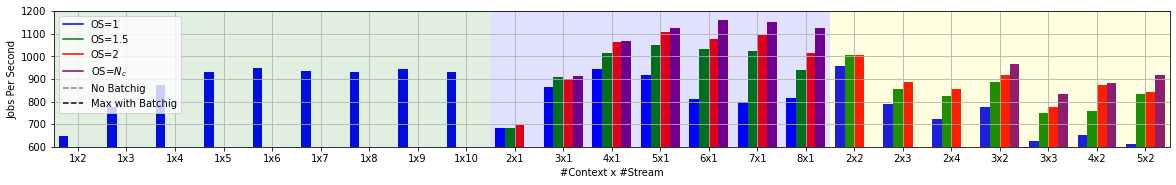

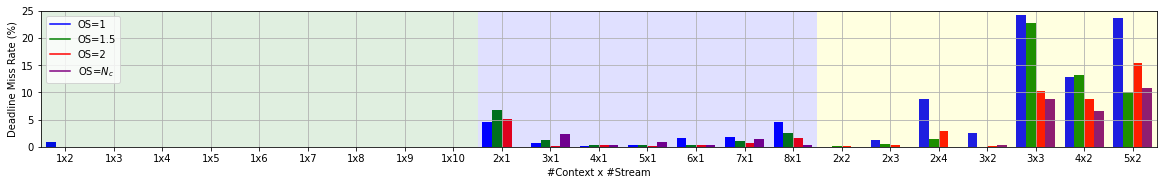

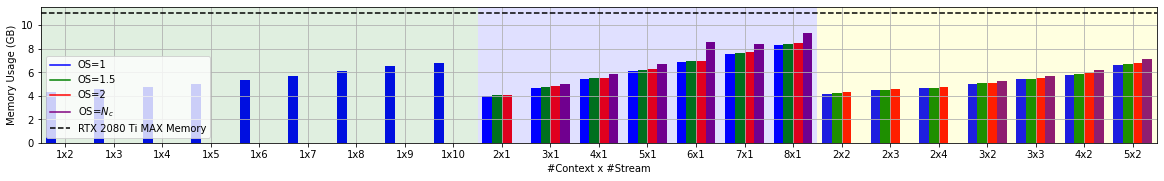

<Figure size 1440x180 with 0 Axes>

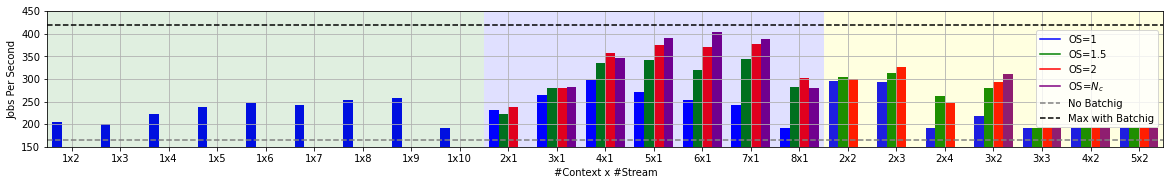

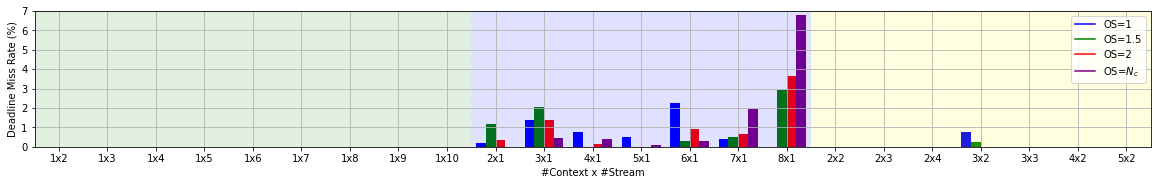

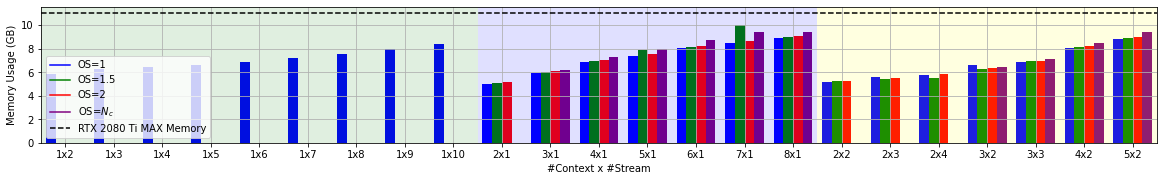

<Figure size 1440x180 with 0 Axes>

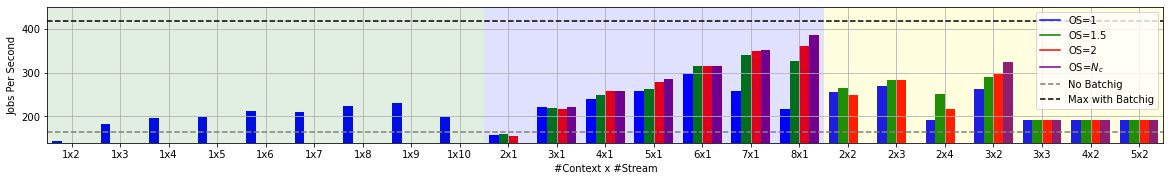

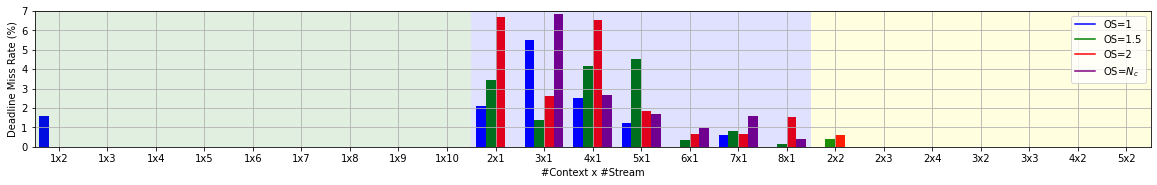

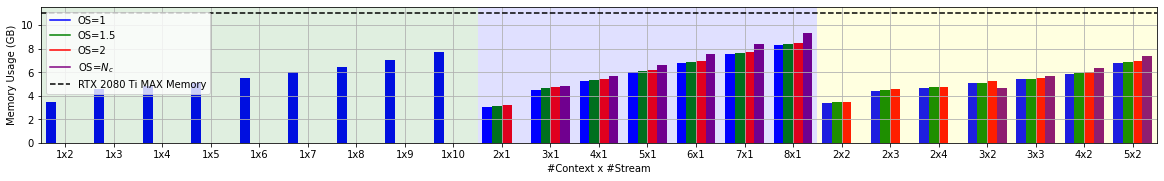

In [119]:
from collections import defaultdict

ctx_list1 = [1]
str_max1 = [10]

ctx_list2 = [2, 3, 4, 5, 6, 7, 8]
str_max2 = [1, 1, 1, 1, 1, 1, 1]

ctx_list3 = [2, 3, 4, 5]
str_max3 = [4, 3, 2, 2]

alpha = 0.12
bColor = ['green', 'blue', 'yellow']

maxSTR = [defaultdict(list) for i in range(3)]
maxMPS = [defaultdict(list) for i in range(3)]
maxMSR = [defaultdict(list) for i in range(3)]

for ts in range(3):	
	plt.figure(ts * 4 + 0, figsize=(20, 2.5))
	plt.figure(ts * 4 + 1, figsize=(20, 2.5))
	plt.figure(ts * 4 + 2, figsize=(20, 2.5))
	plt.figure(ts * 4 + 3, figsize=(20, 2.5))

	x_start = 1
	x_labels = []
	maxJPS = 0

	x_start, x_labels, max_jps = graphAllOversubscribtionFPS(ts, ctx_list1, str_max1, x_start, x_labels)

	for key, value in max_jps.items():
		for v in value:
			maxSTR[ts][key].append(v)

			if maxJPS < v:
				maxJPS = v

	plt.figure(ts * 4 + 0)
	plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)
	plt.figure(ts * 4 + 1)
	plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)
	plt.figure(ts * 4 + 3)
	plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)


	x_start, x_labels, max_jps = graphAllOversubscribtionFPS(ts, ctx_list2, str_max2, x_start, x_labels)

	for key, value in max_jps.items():
		for v in value:
			maxMPS[ts][key].append(v)

			if maxJPS < v:
				maxJPS = v

	plt.figure(ts * 4 + 0)
	plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)
	plt.figure(ts * 4 + 1)
	plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)
	plt.figure(ts * 4 + 3)
	plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)


	x_start, x_labels, max_jps = graphAllOversubscribtionFPS(ts, ctx_list3, str_max3, x_start, x_labels)

	for key, value in max_jps.items():
		for v in value:
			maxMSR[ts][key].append(v)

			if maxJPS < v:
				maxJPS = v

	plt.figure(ts * 4 + 0)
	plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)
	plt.figure(ts * 4 + 1)
	plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)
	plt.figure(ts * 4 + 3)
	plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)



	hColors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
	lColors = ['cyan', 'lime', 'pink', 'magenta', 'yellow', 'gray']

	legend_handles = [
		mlines.Line2D([], [], color=hColors[0], label='OS=1'),
		mlines.Line2D([], [], color=hColors[1], label='OS=1.5'),
		mlines.Line2D([], [], color=hColors[2], label='OS=2'),
		mlines.Line2D([], [], color=hColors[3], label='OS=$N_c$'),
		mlines.Line2D([], [], color='gray', label='No Batchig', linestyle='--'),
		mlines.Line2D([], [], color='black', label='Max with Batchig', linestyle='--')]
	
	y_lim = [
		[600, 1200],
		[150, 450],
		[140, 450]
	]

	plt.figure(ts * 4)
	plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
	plt.xlabel('#Context x #Stream')
	plt.ylabel('Jobs Per Second')
	plt.axhline(y=maxBatchingFPS[2], color='black', linestyle='--')
	plt.axhline(y=minBatchingFPS[2], color='gray', linestyle='--')
	plt.legend(handles=legend_handles)
	plt.ylim(y_lim[ts])
	plt.grid(True)
	plt.xlim(0.5, x_start - 0.5)

	y_lim = [
		[0, 25],
		[0, 7],
		[0, 7]
	]

	legend_handles = [
		mlines.Line2D([], [], color=hColors[0], label='OS=1'),
		mlines.Line2D([], [], color=hColors[1], label='OS=1.5'),
		mlines.Line2D([], [], color=hColors[2], label='OS=2'),
		mlines.Line2D([], [], color=hColors[3], label='OS=$N_c$')]

	
	plt.figure(ts * 4 + 1)
	plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
	plt.xlabel('#Context x #Stream')
	plt.ylabel('Deadline Miss Rate (%)')
	plt.legend(handles=legend_handles)
	plt.grid(True)
	plt.ylim(y_lim[ts])
	plt.xlim(0.5, x_start - 0.5)

	if ts > 0:
		plt.yticks(np.arange(0, 8, 1))

	legend_handles = [
		mlines.Line2D([], [], color=hColors[0], label='OS=1'),
		mlines.Line2D([], [], color=hColors[1], label='OS=1.5'),
		mlines.Line2D([], [], color=hColors[2], label='OS=2'),
		mlines.Line2D([], [], color=hColors[3], label='OS=$N_c$'),
		mlines.Line2D([], [], color='black', label='RTX 2080 Ti MAX Memory', linestyle='--')]

	plt.figure(ts * 4 + 3)
	plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
	plt.xlabel('#Context x #Stream')
	plt.ylabel('Memory Usage (GB)')
	plt.axhline(y=11, color='black', linestyle='--')
	plt.grid(True)
	plt.xlim(0.5, x_start - 0.5)
	plt.legend(handles=legend_handles)

	for item, value in maxSTR[ts].items():
		newValue = [v / maxJPS for v in value]
		maxSTR[ts][item] = newValue
	
	for item, value in maxMPS[ts].items():
		newValue = [v / maxJPS for v in value]
		maxMPS[ts][item] = newValue

	for item, value in maxMSR[ts].items():
		newValue = [v / maxJPS for v in value]
		maxMSR[ts][item] = newValue

overallSTR = defaultdict(list)

for i in range(3):
	for key, value in maxSTR[i].items():
		overallSTR[key].extend(value)
		
overallMPS = defaultdict(list)

for i in range(3):
	for key, value in maxMPS[i].items():
		overallMPS[key].extend(value)

overallMSR = defaultdict(list)

for i in range(3):
	for key, value in maxMSR[i].items():
		overallMSR[key].extend(value)

In [6]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def graphAllOversubscribtionFPSMixed(ctx_list, str_max, x_start, x_labels):
	for ctx in ctx_list:
		coefs = [5, 2, 3]
		cases = 4
		fps = [[] for i in range(cases)]
		hdm = [[] for i in range(cases)]
		ldm = [[] for i in range(cases)]
		
		customOsOptions = osOptions.copy()

		if ctx == 1:
			customOsOptions = [1]

		if ctx > 2:
			customOsOptions.append(ctx)
			
		strMin = 1

		if ctx == 1:
			strMin = 2
		else:
			strMin = 1
			
		strMax = str_max[ctx - ctx_list[0]]
		
		if ctx != 1 and strMax != 1:
			strMin = 2

		x = np.arange(x_start, x_start + strMax - strMin + 1)

		for stream in range(strMin, strMax + 1):
			index = 0

			for os in customOsOptions:
				_, sum1 = getScenario(0, ctx, stream, os)
				_, sum2 = getScenario(1, ctx, stream, os)
				_, sum3 = getScenario(2, ctx, stream, os)

				fps[index].append(sum1.fps + sum2.fps + sum3.fps)
				hdm[index].append((sum1.hMiss * coefs[0] + sum2.hMiss * coefs[1] + sum3.hMiss * coefs[2]) / sum(coefs))
				ldm[index].append((sum1.lMiss * coefs[0] + sum2.lMiss * coefs[1] + sum3.lMiss * coefs[2]) / sum(coefs))

				index += 1
			x_labels.append(str(ctx) + 'x' + str(stream))

		hColors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
		lColors = ['cyan', 'lime', 'pink', 'magenta', 'yellow', 'gray']
		index = 0

		for os in customOsOptions:
			plt.figure(0)
			plt.bar(x + (index * 0.2 - 0.3), fps[index], 0.2, label='OS: ' + str(os), color=hColors[index])
			
			plt.figure(1)
			plt.bar(x + (index * 0.2 - 0.3), ldm[index], 0.2, label='low_OS: ' + str(os), color=hColors[index])
			
			plt.figure(2)
			plt.bar(x + (index * 0.2 - 0.3), hdm[index], 0.2, label='low_OS: ' + str(os), color=hColors[index])

			index += 1

		x_start += strMax - strMin + 1

	return (x_start, x_labels)


(0.5, 11.5)

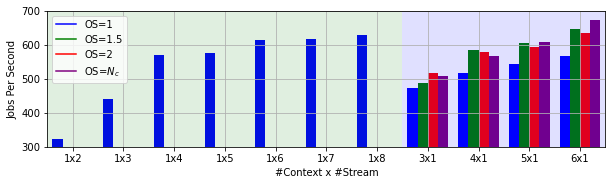

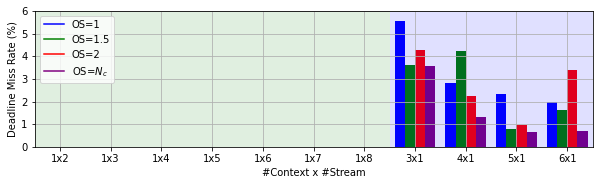

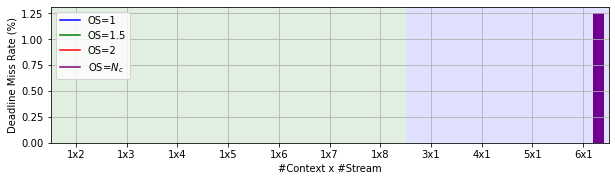

In [120]:
ctx_list1 = [1]
str_max1 = [8]

ctx_list2 = [3, 4, 5, 6]
str_max2  = [1, 1, 1, 1]

ctx_list3 = [2, 3, 4, 5]
str_max3 = [4, 3, 2, 2]

alpha = 0.12
bColor = ['green', 'blue', 'yellow']

plt.figure(0, figsize=(10, 2.5))
plt.figure(1, figsize=(10, 2.5))
plt.figure(2, figsize=(10, 2.5))

x_start = 1
x_labels = []

x_start, x_labels = graphAllOversubscribtionFPSMixed(ctx_list1, str_max1, x_start, x_labels)
plt.figure(0)
plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)
plt.figure(1)
plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)
plt.figure(2)
plt.axvspan(0, str_max1[0] - 0.5, facecolor=bColor[0], alpha=alpha)

x_start, x_labels = graphAllOversubscribtionFPSMixed(ctx_list2, str_max2, x_start, x_labels)
plt.figure(0)
plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)
plt.figure(1)
plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)
plt.figure(2)
plt.axvspan(str_max1[0] - 0.5, x_start - 0.5, facecolor=bColor[1], alpha=alpha)

# x_start, x_labels = graphAllOversubscribtionFPSMixed(ctx_list3, str_max3, x_start, x_labels)
# plt.figure(0)
# plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)
# plt.figure(1)
# plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)
# plt.figure(2)
# plt.axvspan(str_max1[0] + len(str_max2) - 0.5, x_start + 0.5, facecolor=bColor[2], alpha=alpha)

hColors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
lColors = ['cyan', 'lime', 'pink', 'magenta', 'yellow', 'gray']

legend_handles = [
	mlines.Line2D([], [], color=hColors[0], label='OS=1'),
	mlines.Line2D([], [], color=hColors[1], label='OS=1.5'),
	mlines.Line2D([], [], color=hColors[2], label='OS=2'),
	mlines.Line2D([], [], color=hColors[3], label='OS=$N_c$')]

y_lim = [300, 700]

plt.figure(0)
plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
plt.xlabel('#Context x #Stream')
plt.ylabel('Jobs Per Second')
plt.legend(handles=legend_handles)
plt.ylim(y_lim)
plt.grid(True)
plt.xlim(0.5, x_start - 0.5)

y_lim = [0, 6]

legend_handles = [
	mlines.Line2D([], [], color=hColors[0], label='OS=1'),
	mlines.Line2D([], [], color=hColors[1], label='OS=1.5'),
	mlines.Line2D([], [], color=hColors[2], label='OS=2'),
	mlines.Line2D([], [], color=hColors[3], label='OS=$N_c$')]

plt.figure(1)
plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
plt.xlabel('#Context x #Stream')
plt.ylabel('Deadline Miss Rate (%)')
plt.legend(handles=legend_handles)
plt.grid(True)
plt.ylim(y_lim)
plt.xlim(0.5, x_start - 0.5)
# plt.yticks(np.arange(0, 8, 1))

plt.figure(2)
plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
plt.xlabel('#Context x #Stream')
plt.ylabel('Deadline Miss Rate (%)')
plt.legend(handles=legend_handles)
plt.grid(True)
# plt.ylim(y_lim)
plt.xlim(0.5, x_start - 0.5)
# plt.yticks(np.arange(0, 8, 1))

In [8]:
import statistics

class Detail:
	def __init__(self, ts, ctx, stream, os, et, rt, wcet, wret):
		self.ts = ts
		self.ctx = ctx
		self.stream = stream
		self.os = os
		
		self.et = et
		self.rt = rt
		self.wcet = wcet
		self.wret = wret

		self.text = longTaskset[ts] + '\n'
		self.text += 'CTX: ' + str(ctx) + '\n'
		self.text += 'Stream: ' + str(stream) + '\n'
		self.text += 'OS: ' + str(os)
		
	def __str__(self):
		return self.text

In [9]:
def getScenarioDetail(ts, ctx, stream, os):
	def float_to_string(num):
		return ('{:.2f}'.format(num).rstrip('0').rstrip('.') if num % 1 else '{:.0f}'.format(num))
	
	def read_data(directory):
		with open(directory, 'r') as file:
			lines = file.readlines()

		data = []

		for line in lines[1:]:
			line = line.replace(', ', 's')
			line = line.replace(',', '')

			if line == '':
				continue

			if line[-1] == 's':
				line = line[:-1]
			
			columns = line.strip().split('s')
			numeric_columns = [int(col) for col in columns]
			data.append(numeric_columns)
		
		return data

	dir = ['res/', 'unt/', 'inc/']

	fileEtHS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/etH.csv')
	fileEtLS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/etL.csv')

	fileRtHS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/rtH.csv')
	fileRtLS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/rtL.csv')

	fileWcetHS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wcetH.csv')
	fileWcetLS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wcetL.csv')
	
	fileWretHS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wretH.csv')
	fileWretLS = read_data(mainDirectory + dir[ts] + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wretL.csv')

	fileEtHM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'etH.csv')
	fileEtLM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'etL.csv')
	
	fileRtHM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'rtH.csv')
	fileRtLM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'rtL.csv')

	fileWcetHM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'wcetH.csv')
	fileWcetLM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'wcetL.csv')
	
	fileWretHM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'wretH.csv')
	fileWretLM = read_data(mainDirectory + 'mix/' + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/' + dir[ts] + 'wretL.csv')

	etHS = fileEtHS
	etLS = fileEtLS

	rtHS = fileRtHS
	rtLS = fileRtLS

	wcetHS = fileWcetHS
	wcetLS = fileWcetLS

	wretHS = fileWretHS
	wretLS = fileWretLS

	etHM = fileEtHM
	etLM = fileEtLM

	rtHM = fileRtHM
	rtLM = fileRtLM

	wcetHM = fileWcetHM
	wcetLM = fileWcetLM

	wretHM = fileWretHM
	wretLM = fileWretLM

	

	detSH = Detail(ts, ctx, stream, os, etHS, rtHS, wcetHS, wretHS)
	detSL = Detail(ts, ctx, stream, os, etLS, rtLS, wcetLS, wretLS)
	detMH = Detail(ts, ctx, stream, os, etHM, rtHM, wcetHM, wretHM)
	detML = Detail(ts, ctx, stream, os, etLM, rtLM, wcetLM, wretLM)

	return (detSH, detSL, detMH, detML)

In [10]:
import matplotlib.lines as mlines

def flatten_list_of_lists(list_of_lists):
  return [item for sublist in list_of_lists for item in sublist]

def pad_list(lst, length):
	while lst.shape[0] < length:
		lst = np.append(lst, np.nan)
	
	return lst

def plotResponseTime(ts, ctx_list, str_max, x_start, x_labels):

	for ctx in ctx_list:
		customOsOptions = osOptions.copy()

		if ctx == 1:
			customOsOptions = [1]

		if ctx > 2:
			customOsOptions.append(ctx)
			
		strMax = str_max[ctx - ctx_list[0]]
			
		strMin = 1

		if ctx == 1:
			strMin = strMax
		else:
			strMin = 1
		
		if ctx != 1 and strMax != 1:
			strMin = 2

		# if ctx == 8:
		# 	strMax = 1

		x = np.arange(x_start, x_start + strMax - strMin + 1)

		for stream in range(strMin, strMax + 1):
			positions = [[x_start - 0.35], [x_start - 0.25], [x_start - 0.15], [x_start - 0.05], [x_start + 0.05], [x_start + 0.15], [x_start + 0.25], [x_start + 0.35]]
			position_index = 0

			x_labels.append(str(ctx) + 'x' + str(stream))

			for os in customOsOptions:
				detSH, detSL, detMH, detML = getScenarioDetail(ts, ctx, stream, os)

				flatSHEt = np.ravel(flatten_list_of_lists(detSH.et)) / 1000
				flatSLEt = np.ravel(flatten_list_of_lists(detSL.et)) / 1000

				lStyle = {'color' : colors[position_index], 'linestyle' : '-'}
				hStyle = {'color' : colors[position_index], 'linestyle' : ':'}

				plt.figure(ts * 2)
				plt.boxplot([flatSHEt], widths=0.07, positions=positions[position_index], showfliers=False, whis=(5, 95),
								boxprops=lStyle, whiskerprops=lStyle, capprops=lStyle)
				plt.boxplot([flatSLEt], widths=0.07, positions=positions[position_index + 4], showfliers=False, whis=(5, 95),
								boxprops=hStyle, whiskerprops=hStyle, capprops=hStyle)

				flatSHRt = np.ravel(flatten_list_of_lists(detSH.rt)) / 1000
				flatSLRt = np.ravel(flatten_list_of_lists(detSL.rt)) / 1000

				plt.figure(ts * 2 + 1)
				plt.boxplot([flatSHRt], widths=0.07, positions=positions[position_index], showfliers=False, whis=(5, 95),
								boxprops=lStyle, whiskerprops=lStyle, capprops=lStyle)
				plt.boxplot([flatSLRt], widths=0.07, positions=positions[position_index + 4], showfliers=False, whis=(5, 95),
								boxprops=hStyle, whiskerprops=hStyle, capprops=hStyle)

				position_index += 1

			x_start += 1

	return (x_start, x_labels)

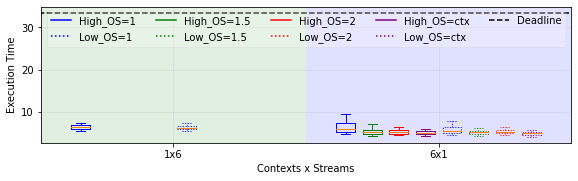

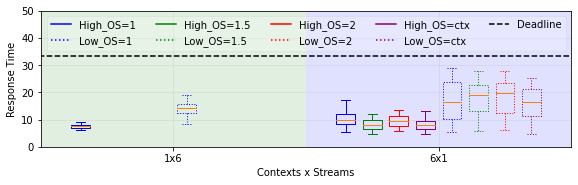

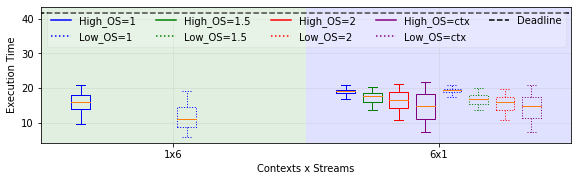

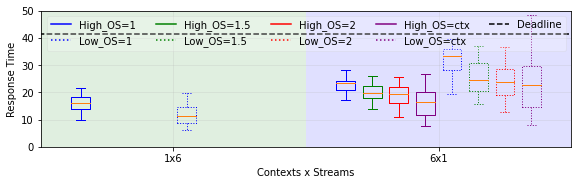

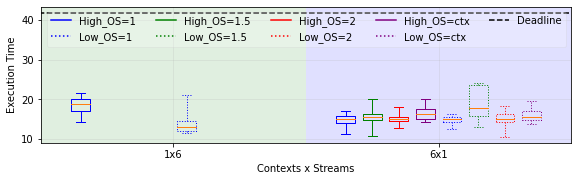

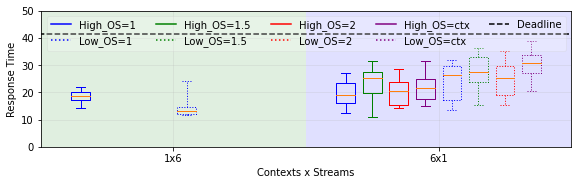

In [11]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']
t = [33.333, 41.667, 41.667]

ctx_list1 = [1]
str_max1 = [6]

ctx_list2 = [6]
str_max2  = [1]

ctx_list3 = [2, 3, 4, 5]
str_max3 = [4, 3, 2, 2]

for ts in range(3):
	x_start = 1
	x_labels = []

	plt.figure(ts * 2 + 0, figsize=(9.5, 2.5))
	plt.figure(ts * 2 + 1, figsize=(9.5, 2.5))

	x_start, x_labels = plotResponseTime(ts, ctx_list1, str_max1, x_start, x_labels)
	plt.figure(ts * 2 + 0)
	plt.axvspan(0, 2 - 0.5, facecolor=bColor[0], alpha=alpha)
	plt.figure(ts * 2 + 1)
	plt.axvspan(0, 2 - 0.5, facecolor=bColor[0], alpha=alpha)

	x_start, x_labels = plotResponseTime(ts, ctx_list2, str_max2, x_start, x_labels)
	plt.figure(ts * 2 + 0)
	plt.axvspan(2 - 0.5, 3 - 0.5, facecolor=bColor[1], alpha=alpha)
	plt.figure(ts * 2 + 1)
	plt.axvspan(2 - 0.5, 3 - 0.5, facecolor=bColor[1], alpha=alpha)

	legend_handles = [
		mlines.Line2D([], [], color=colors[0], label='High_OS=1', linestyle='-'),
		mlines.Line2D([], [], color=colors[0], label='Low_OS=1', linestyle=':'),
		mlines.Line2D([], [], color=colors[1], label='High_OS=1.5', linestyle='-'),
		mlines.Line2D([], [], color=colors[1], label='Low_OS=1.5', linestyle=':'),
		mlines.Line2D([], [], color=colors[2], label='High_OS=2', linestyle='-'),
		mlines.Line2D([], [], color=colors[2], label='Low_OS=2', linestyle=':'),
		mlines.Line2D([], [], color=colors[3], label='High_OS=ctx', linestyle='-'),
		mlines.Line2D([], [], color=colors[3], label='Low_OS=ctx', linestyle=':'),
		mlines.Line2D([], [], color=colors[5], label='Deadline', linestyle='--')
	]

	y_lim = [0, 35]

	plt.figure(ts * 2)
	plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
	plt.hlines(t[ts], 0, len(x_labels) + 1, colors='k', linestyles='--')
	plt.xlabel('Contexts x Streams')
	plt.ylabel('Execution Time')
	plt.xlim(0.5, len(x_labels) + 0.5)
	plt.legend(handles=legend_handles, ncol=5, framealpha=0.25)
	plt.grid(True, alpha=0.25)
	# plt.ylim(y_lim)

	y_lim = [0, 50]

	plt.figure(ts * 2 + 1)
	plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
	plt.hlines(t[ts], 0, len(x_labels) + 1, colors='k', linestyles='--')
	plt.xlabel('Contexts x Streams')
	plt.ylabel('Response Time')
	plt.xlim(0.5, len(x_labels) + 0.5)
	plt.legend(handles=legend_handles, ncol=5, framealpha=0.25)
	plt.grid(True, alpha=0.25)
	plt.ylim(y_lim)

In [12]:
def drawWorstCaseScenaro(ts, ctx, stream, os, bias, iters, index):
	detSH, detSL, detMH, detML = getScenarioDetail(ts, ctx, stream, os)
	mColors = ['blue', 'red', 'red', 'purple', 'orange', 'black']
	wColors = ['cyan', 'orange', 'pink', 'magenta', 'yellow', 'gray']
	flatSHEt = np.ravel(flatten_list_of_lists(detSH.et))
	# flatSLEt = np.ravel(flatten_list_of_lists(detSL.et))
	flatSHWt = np.ravel(flatten_list_of_lists(detSH.wret))
	# flatSLWt = np.ravel(flatten_list_of_lists(detSL.wret))

	et = flatSHEt[bias * iters + 1: (bias + 1) * iters] / 1000
	wt = flatSHWt[bias * iters : (bias + 1) * iters - 1] / 1000
	
	x = np.arange(1 / (iters - 2), iters + 1, iters / (iters - 2))

	plt.plot(x, et, color=mColors[index])
	plt.plot(x, wt, color=wColors[index], linestyle='--')
	plt.xlabel('Iteration')
	plt.ylabel('Time (ms)')
	# plt.xticks(np.arange(10, iters + 1, 10))
	plt.xlim(1 / (iters - 2), iters)
	plt.grid(True)
	plt.ylim(2, 18)

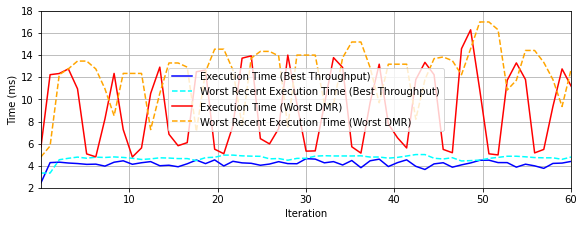

In [121]:
plt.figure(figsize=(9.5, 3.25))
drawWorstCaseScenaro(0, 6, 1, 6, 0, 60, 0)
drawWorstCaseScenaro(0, 3, 3, 1, 0, 60, 1)

mColors = ['blue', 'red', 'red', 'purple', 'orange', 'black']
wColors = ['cyan', 'orange', 'pink', 'magenta', 'yellow', 'gray']

legends = [
	mlines.Line2D([], [], color=mColors[0], label='Execution Time (Best Throughput)', linestyle='-'),
	mlines.Line2D([], [], color=wColors[0], label='Worst Recent Execution Time (Best Throughput)', linestyle='--'),
	mlines.Line2D([], [], color=mColors[1], label='Execution Time (Worst DMR)', linestyle='-'),
	mlines.Line2D([], [], color=wColors[1], label='Worst Recent Execution Time (Worst DMR)', linestyle='--')
]

plt.legend(handles=legends)

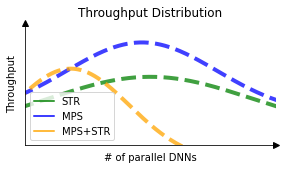

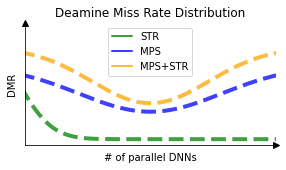

In [50]:
from math import floor, ceil

colors = ['green', 'blue', 'orange']

x = np.linspace(-5, 5, 1000)
mu_values 		= [0, -0.1, -0.95]
sigma_values	= [1.2, 0.9, 0.7]
bias					= [0.35, 0.75, -0.4]

fig, ax = plt.subplots(figsize=(4.5, 2.25))

x_lim = [-1.5, 1.5]
y_lim = [0, -1000]

index = 0
for mu, sigma in zip(mu_values, sigma_values):
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) * 4 + bias[index]
    y_lim[1] = max(y_lim[1], max(y))
    y_lim [1] = ceil(y_lim[1])
    plt.plot(x, y, color=colors[index], linewidth=4, linestyle='--', alpha=0.75)
    index += 1

legends = [
	mlines.Line2D([], [], color='green', label='STR'),
	mlines.Line2D([], [], color='blue', label='MPS'),
	mlines.Line2D([], [], color='orange', label='MPS+STR')]

plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Throughput Distribution')
plt.xlabel('# of parallel DNNs')
plt.ylabel('Throughput')
plt.xticks([10])
plt.yticks([10])
plt.legend(handles=legends)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.plot(1, y_lim[0], ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(x_lim[0], 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

mu_values 		= [-1.99, 0, 0]
sigma_values	= [0.4, -0.85, -0.7]
bias					= [0.25, 3.25, 4]

fig, ax = plt.subplots(figsize=(4.5, 2.25))

x_lim = [-1.5, 1.5]
y_lim = [0, -1000]

index = 0
for mu, sigma in zip(mu_values, sigma_values):
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) * 4 + bias[index]
    y_lim[1] = max(y_lim[1], max(y))
    y_lim [1] = ceil(y_lim[1])
    plt.plot(x, y, color=colors[index], linewidth=4, linestyle='--', alpha=0.75)
    index += 1

y_lim = [0, 5]

plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Deamine Miss Rate Distribution')
plt.xlabel('# of parallel DNNs')
plt.ylabel('DMR')
plt.xticks([10])
plt.yticks([10])
plt.legend(handles=legends)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.plot(1, y_lim[0], ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(x_lim[0], 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

plt.show()

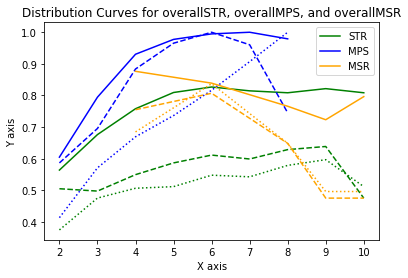

In [15]:
from statistics import mean

x = [[] for i in range(3)]
y = [[] for i in range(3)]

x[0] = [key for key in maxSTR[0].keys()]
y1 = [value for value in maxSTR[0].values()]
y2 = [value for value in maxSTR[1].values()]
y3 = [value for value in maxSTR[2].values()]
y[0] = [mean([y1[i][0], y2[i][0], y3[i][0]]) for i in range(len(y1))]

plt.plot(x[0], y1, color='green')
plt.plot(x[0], y2, color='green', linestyle='--')
plt.plot(x[0], y3, color='green', linestyle=':')

x[1] = [key for key in maxMPS[0].keys()]
y1 = [value for value in maxMPS[0].values()]
y2 = [value for value in maxMPS[1].values()]
y3 = [value for value in maxMPS[2].values()]
y[1] = [mean([y1[i][0], y2[i][0], y3[i][0]]) for i in range(len(y1))]

plt.plot(x[1], y1, color='blue')
plt.plot(x[1], y2, color='blue', linestyle='--')
plt.plot(x[1], y3, color='blue', linestyle=':')

x[2] = [key for key in maxMSR[0].keys()]
y1 = [max(value) for value in maxMSR[0].values()]
y2 = [max(value) for value in maxMSR[1].values()]
y3 = [max(value) for value in maxMSR[2].values()]

y[2] = [mean([y1[i], y2[i], y3[i]]) for i in range(len(y1))]

plt.plot(x[2], y1, color='orange')
plt.plot(x[2], y2, color='orange', linestyle='--')
plt.plot(x[2], y3, color='orange', linestyle=':')

# plt.plot(x[0], y[0], color='green')
# plt.plot(x[1], y[1], color='blue')
# plt.plot(x[2], y[2], color='orange')

# Adding labels and legend
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Distribution Curves for overallSTR, overallMPS, and overallMSR')

legends = [
	mlines.Line2D([], [], color='green', label='STR'),
	mlines.Line2D([], [], color='blue', label='MPS'),
	mlines.Line2D([], [], color='orange', label='MSR')]

plt.legend(handles=legends)
plt.show()

In [123]:
def getResponseTimeScenarioDetail(path, ctx, stream, os):
	def float_to_string(num):
		return ('{:.2f}'.format(num).rstrip('0').rstrip('.') if num % 1 else '{:.0f}'.format(num))
	
	def read_data(directory):
		with open(directory, 'r') as file:
			lines = file.readlines()

		data = []

		for line in lines[1:]:
			line = line.replace(', ', 's')
			line = line.replace(',', '')

			if line == '':
				continue

			if line[-1] == 's':
				line = line[:-1]
			
			columns = line.strip().split('s')
			numeric_columns = [int(col) for col in columns]
			data.append(numeric_columns)
		
		return data

	dir = path + '/'

	fileEtHS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/etH.csv')
	fileEtLS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/etL.csv')

	fileRtHS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/rtH.csv')
	fileRtLS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/rtL.csv')

	fileWcetHS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wcetH.csv')
	fileWcetLS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wcetL.csv')
	
	fileWretHS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wretH.csv')
	fileWretLS = read_data(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/wretL.csv')

	etHS = fileEtHS
	etLS = fileEtLS

	rtHS = fileRtHS
	rtLS = fileRtLS

	wcetHS = fileWcetHS
	wcetLS = fileWcetLS

	wretHS = fileWretHS
	wretLS = fileWretLS

	detSH = Detail(ts, ctx, stream, os, etHS, rtHS, wcetHS, wretHS)
	detSL = Detail(ts, ctx, stream, os, etLS, rtLS, wcetLS, wretLS)

	fileSum = pd.read_csv(mainDirectory + dir + str(ctx) + '/' + str(stream) + '/' + float_to_string(os) + '/summary.csv')

	fileSum_numeric = fileSum.apply(pd.to_numeric, errors='coerce').fillna(0)
	
	dataSumMax = fileSum_numeric.max(axis=0)
	dataSumMean = fileSum_numeric.mean(axis=0)

	return (detSH, detSL, dataSumMax[0])

In [124]:
import matplotlib.lines as mlines

def flatten_list_of_lists(list_of_lists):
  return [item for sublist in list_of_lists for item in sublist]

def pad_list(lst, length):
	while lst.shape[0] < length:
		lst = np.append(lst, np.nan)
	
	return lst

def plotResponseTime(path, ctx, stream, os, x_start, x_labels, color, fps):
	x = np.arange(x_start, x_start + 1)
	positions = [[x_start - 0.2], [x_start + 0.2]]

	x_labels.append(str(ctx) + 'x' + str(stream))
	detSH, detSL, temp = getResponseTimeScenarioDetail(path, ctx, stream, os)
	fps.append(temp)

	lStyle = {'color' : color, 'linestyle' : '-'}
	hStyle = {'color' : color, 'linestyle' : ':'}

	flatSHRt = np.ravel(flatten_list_of_lists(detSH.rt)) / 1000
	flatSLRt = np.ravel(flatten_list_of_lists(detSL.rt)) / 1000


	print(f'{path}:\n\tMin: {min(flatSHRt)}, {min(flatSLRt)}\n\tMax: {max(flatSHRt)}, {max(flatSLRt)}')

	plt.boxplot([flatSHRt], widths=0.3, positions=positions[0], showfliers=False, whis=(5, 98),
					boxprops=lStyle, whiskerprops=lStyle, capprops=lStyle)
	plt.boxplot([flatSLRt], widths=0.3, positions=positions[1], showfliers=False, whis=(5, 98),
					boxprops=hStyle, whiskerprops=hStyle, capprops=hStyle)

	x_start += 1

	return (x_start, x_labels, fps)

res:
	Min: 1.704, 1.916
	Max: 13.181, 33.495
resSingle:
	Min: 1.49, 1.625
	Max: 15.759, 39.984
resLast:
	Min: 1.653, 1.988
	Max: 20.321, 34.008
resPrior:
	Min: 1.837, 2.157
	Max: 17.673, 38.429
resFix:
	Min: 1.709, 2.296
	Max: 42.304, 42.476


(0.65, 1.01)

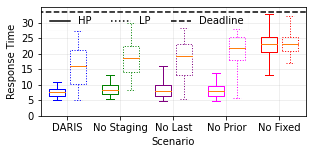

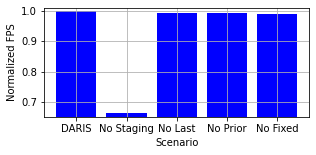

In [125]:
colors = ['blue', 'green', 'purple', 'magenta', 'red', 'black', 'cyan', 'magenta', 'yellow']
deadline = 33.333

x_start = 1
x_labels = []

ctx = 6
stream = 1
os = 6

fps = []

plt.figure(0, figsize=(4.75, 2))

x_start, x_labels, fps = plotResponseTime("res", ctx, stream, os, x_start, x_labels, colors[0], fps)
x_start, x_labels, fps = plotResponseTime("resSingle", ctx, stream, os, x_start, x_labels, colors[1], fps)
x_start, x_labels, fps = plotResponseTime("resLast", ctx, stream, os, x_start, x_labels, colors[2], fps)
x_start, x_labels, fps = plotResponseTime("resPrior", ctx, stream, os, x_start, x_labels, colors[3], fps)
x_start, x_labels, fps = plotResponseTime("resFix", ctx, stream, os, x_start, x_labels, colors[4], fps)
# x_start, x_labels = plotResponseTime("resWS10", ctx, stream, os, x_start, x_labels, colors[5])

legend_handles = [
	mlines.Line2D([], [], color='black', label='HP', linestyle='-'),
	mlines.Line2D([], [], color='black', label='LP', linestyle=':'),
	mlines.Line2D([], [], color='black', label='Deadline', linestyle='--')
]

y_lim = [0, 35]

x_labels = ['DARIS', 'No Staging', 'No Last', 'No Prior', 'No Fixed']

plt.xticks(np.arange(1, len(x_labels) + 1), x_labels)
plt.hlines(deadline, 0, len(x_labels) + 1, colors='k', linestyles='--')
plt.xlabel('Scenario')
plt.ylabel('Response Time')
plt.xlim(0.5, len(x_labels) + 0.5)
# plt.legend(handles=legend_handles, ncol=5, framealpha=0.25)
plt.legend(handles=legend_handles, ncol=3, framealpha=0.05)
plt.grid(True, alpha=0.25)
plt.yticks(np.arange(0, 35, 5))
plt.ylim(y_lim)

fps = [f / max(fps) for f in fps]

plt.figure(1, figsize=(4.75, 2))
plt.bar(x_labels, fps, color='blue')
plt.xlabel('Scenario')
plt.ylabel('Normalized JPS')
# plt.legend(handles=legend_handles)
plt.grid(True)
plt.ylim(0.65, 1.01)